In [113]:
from pathlib import Path
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

In [114]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, labels_file, transform=None):
        self.data_dir = data_dir
        self.labels_df = pd.read_csv(labels_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.data_dir / f"img_{self.labels_df.iloc[idx]['id']}.png"
        image = Image.open(img_path).convert('RGB')
        label = self.labels_df.iloc[idx]['malignant']

        if self.transform:
            image = self.transform(image)
        sample = {'image': image,
                  'label': label,
                  'id': self.labels_df.iloc[idx]['id']}
        return sample

In [115]:
def show_imgs(ims, captions=None):
    fig, ax = plt.subplots(nrows=1, ncols=len(ims), figsize=(10, 5))
    for i in range(len(ims)):
        ax[i].imshow(ims[i])
        ax[i].axis('off')
        if captions is not None:
          ax[i].set_title(captions[i], fontweight="bold")

In [116]:
# Set random seed for reproducibility
torch.manual_seed(2)

In [117]:
# read in the data
data_dir = Path("/content/data")

In [118]:
# unzip data
! unzip -q /content/data/oxml-carinoma-classification.zip -d /content/data/

replace /content/data/img_103601.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [119]:
labels_file = data_dir / 'labels.csv'
data_df = pd.read_csv(labels_file)
data_df

,id,malignant
0,441,-1
1,33284,-1
2,38771,1
3,46784,-1
4,57613,-1
...,...,...
57,918503,-1
58,931650,-1
59,955514,0
60,965412,-1


# Load data

In [131]:
# Define any image transformations if needed
# transform = torchvision.transforms.Compose([...])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(), # augment the data
    transforms.ToTensor(),
    # Rescale pixel to [-1, 1] values.
    # The first tuple (0.5, 0.5, 0.5) is the mean for all three
    # channels and the second (0.5, 0.5, 0.5) is the standard
    # deviation for all three channels.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [132]:
# Create the custom dataset
dataset = CustomDataset(data_dir, labels_file, transform)

In [133]:
# Create the data loader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [134]:
sample = next(iter(dataloader))
print(f"Image shape: {sample['image'].shape} Labels shape: {sample['label'].shape}")

Image shape: torch.Size([16, 3, 224, 224]) Labels shape: torch.Size([16])


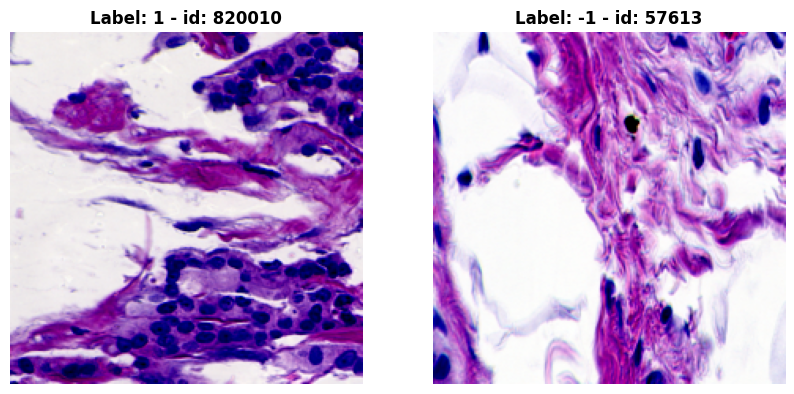

In [135]:
show_imgs([sample["image"][1].permute(1, 2, 0), sample["image"][2].permute(1, 2, 0)],
          captions=[f"Label: {sample['label'][1]} - id: {sample['id'][1]}",
                    f"Label: {sample['label'][2]} - id: {sample['id'][2]}"])